In [1]:
# Libraries
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import pickle
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from dotenv import load_dotenv
from supabase import create_client
import os

In [2]:
# Read data
load_dotenv()

SUPABASE_URL = os.getenv("NEXT_PUBLIC_SUPABASE_URL")
SUPABASE_SERVICE_KEY = os.getenv("NEXT_PUBLIC_SUPABASE_SERVICE_KEY")

supabase = create_client(SUPABASE_URL, SUPABASE_SERVICE_KEY)

MAKE = "Lamborghini"
min_observations = 10

response = (
    supabase.table("bat_completed_auctions")
    .select("year, model, mileage, normalized_color, transmission, sold_price, bid_amount, end_date, status")
    .eq("make", MAKE)
    .not_.is_("mileage", None)
    .not_.is_("transmission", None)
    .execute()
)
df = pd.DataFrame(response.data)

In [3]:
# Count by model
counts = df[['model','status']].groupby('model').count().sort_values(by='status',ascending=False)
print(counts)

                                                status
model                                                 
Gallardo 6-Speed                                    23
Countach 25th Anniversary                           21
Huracan STO                                         20
Diablo                                              18
Diablo VT Roadster                                  18
...                                                ...
Huracan Performante Coupe                            1
Countach LP500 S Project                             1
Gallardo LP570-4 Performante Spyder                  1
Huracan Super Trofeo EVO 10th Edition Race Car       1
Urus S                                               1

[145 rows x 1 columns]


In [4]:
# Price by model
display_p=df[['model','year','sold_price']]

fig=px.box(display_p,x="model",y="sold_price")
fig.update_layout(title_text='Price vs Model',xaxis_title="Model",yaxis_title="Average Price")

In [5]:
# Filter to models with more than min_observations
counts=df['model'].value_counts()
frequent_models = counts[counts >= min_observations].index

# Filter the data to frequent models
df = df[df['model'].isin(frequent_models)]
popular_labels=frequent_models

colors=['lightslategray',]*len(popular_labels)
colors[0]='crimson'

fig=go.Figure(data=[go.Bar(x=counts[:25],y=popular_labels,marker_color=colors,orientation='h')])
fig.update_layout(title_text='Most represented Models in the Dataset',xaxis_title="Count",yaxis_title="Model")

In [6]:
#distribution of number of cars over the years
dic = {1970+i : sum(df['year']==1970+i) for i in range(55)}
x_dic = [1970 + i for i in range(55)]
y_dic = [dic[1970 + i] for i in range(55)]

# Plot
fig = go.Figure([go.Bar(x=x_dic, y=y_dic)])

fig.update_layout(title="Car year distribution",
                  xaxis_title="Year",
                  yaxis_title="Count Cars sold")


fig.show()

In [7]:
# Distribution of transmission
data_pie = df['transmission'].value_counts()

fig = go.Figure(data=[go.Pie(labels=data_pie.index, values=data_pie.tolist(), textinfo='label+percent',insidetextorientation='radial')])

fig.update_traces(hole=.3, hoverinfo="label+percent+name")

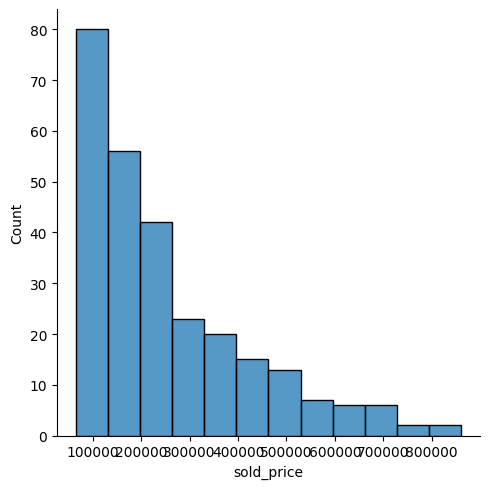

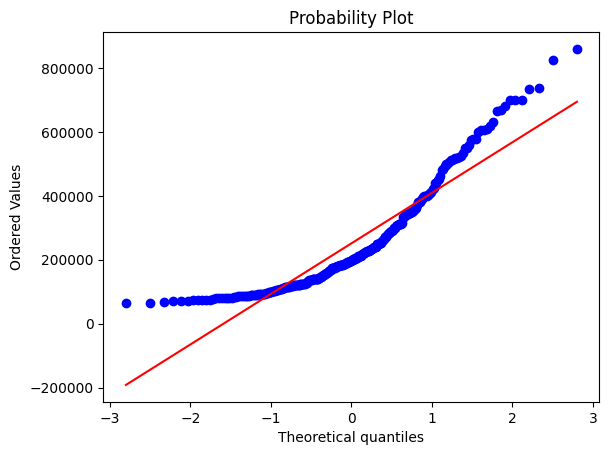

In [8]:
# Replace sold_price with bid_amount and remove outliers
df['sold_price'] = df['sold_price'].fillna(df['bid_amount'])
df = df.dropna()

# Remove outliers
price_threshold = 1000000
df.drop(df[df['sold_price'] >= price_threshold].index,inplace=True)

# Plot distribution of sold_price
sns.displot(df['sold_price'])
fig = plt.figure()
res = stats.probplot(df['sold_price'], plot=plt)


array([[<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'mileage'}>],
       [<Axes: title={'center': 'sold_price'}>,
        <Axes: title={'center': 'bid_amount'}>]], dtype=object)

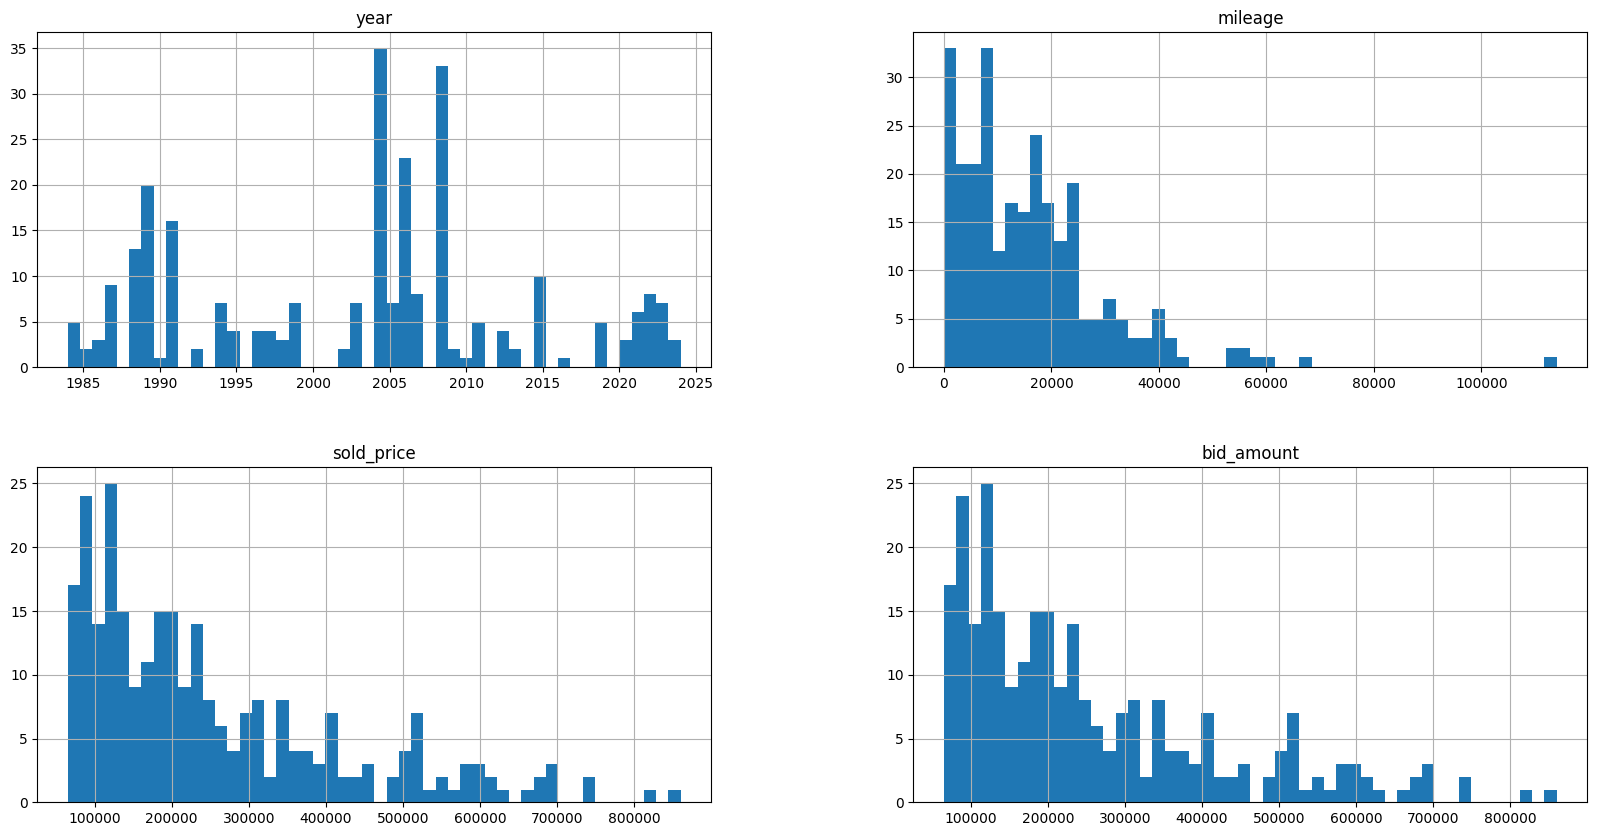

In [9]:
# Data distribution
df.hist(figsize=(20,10),bins = 50)

In [10]:
# Weight by recency
df['days_since_end'] = (pd.to_datetime(date.today()) - pd.to_datetime(df["end_date"])).dt.days
K = 1
T = 360
df['W'] = K*np.exp(-df['days_since_end']/T)


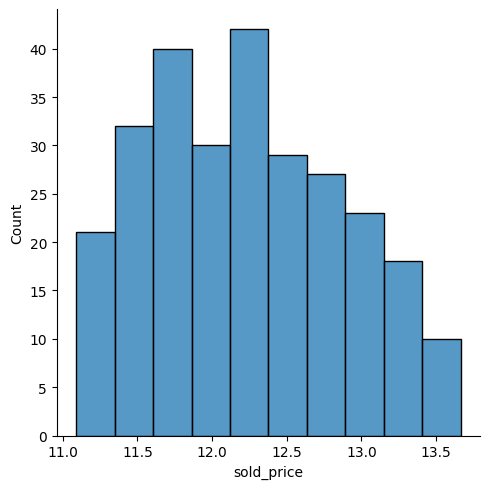

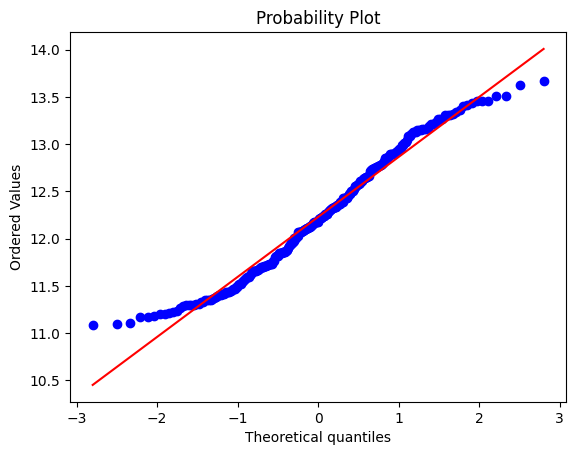

In [11]:
#Log transform sold_price & mileage
df['sold_price'] = np.log(df['sold_price'])
df['mileage'] = np.log1p(df['mileage'])

sns.displot(df['sold_price'])
fig = plt.figure()
res = stats.probplot(df['sold_price'], plot=plt)

In [12]:
# Summarize transformed data
df.describe()

,year,mileage,sold_price,bid_amount,days_since_end,W
count,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000
mean,2002.768382,9.141764,12.229604,251268.275735,803.047794,0.242383
std,10.767658,1.345373,0.637878,168522.581111,584.269331,0.252050
min,1984.000000,3.663562,11.089805,65500.000000,1.000000,0.000182
25%,1991.000000,8.699681,11.709719,121750.000000,377.750000,0.051475
50%,2004.000000,9.472782,12.193414,197500.000000,694.500000,0.145270
75%,2008.000000,9.998843,12.734492,339250.000000,1068.000000,0.350181
max,2024.000000,11.643962,13.664688,860000.000000,3101.000000,0.997226


In [13]:
# Prepare target and features
y = df["sold_price"]
X = df.drop(["sold_price","bid_amount","end_date", "status", "days_since_end"],axis=1)
X

,year,model,mileage,normalized_color,transmission,W
64,1989,Countach 25th Anniversary,8.732466,Black,manual,0.761685
66,1989,Countach 25th Anniversary,8.006701,Black,manual,0.724537
67,1989,Countach 25th Anniversary,8.732466,Black,manual,0.529347
68,1989,Countach 25th Anniversary,9.998843,Red,manual,0.445600
69,1989,Countach 25th Anniversary,8.699681,Black,manual,0.325556
...,...,...,...,...,...,...
548,2021,Urus,8.699681,Gray,automatic,0.148740
549,2022,Urus,7.601402,Black,automatic,0.085577
550,2019,Urus,4.615121,Blue,automatic,0.006909
551,2019,Urus,9.852247,Blue,automatic,0.116484


In [14]:
# Encode categorical features
Lbl_model = LabelEncoder()
Lbl_color = LabelEncoder()
Lbl_trans = LabelEncoder()

#df.make=Lbl.fit_transform(df.make)
X.model=Lbl_model.fit_transform(df.model)
print("Model Mapping:", dict(zip(Lbl_model.classes_, Lbl_model.transform(Lbl_model.classes_))))
X.normalized_color=Lbl_color.fit_transform(df.normalized_color)
print("Color Mapping:", dict(zip(Lbl_color.classes_, Lbl_color.transform(Lbl_color.classes_))))
X.transmission =Lbl_trans.fit_transform(df.transmission)
print("Trans Mapping:", dict(zip(Lbl_trans.classes_, Lbl_trans.transform(Lbl_trans.classes_))))
X

Model Mapping: {'Countach 25th Anniversary': 0, 'Countach 5000 QV': 1, 'Diablo': 2, 'Diablo VT': 3, 'Diablo VT Roadster': 4, 'Gallardo': 5, 'Gallardo 6-Speed': 6, 'Gallardo LP570-4 Spyder Performante': 7, 'Gallardo Spyder': 8, 'Gallardo Spyder 6-Speed': 9, 'Gallardo Superleggera': 10, 'Huracan LP610-4 Coupe': 11, 'Huracan STO': 12, 'Jalpa': 13, 'Murcielago 6-Speed': 14, 'Murcielago LP640 Roadster': 15, 'Murcielago Roadster': 16, 'Urus': 17}
Color Mapping: {'Black': 0, 'Blue': 1, 'Gold': 2, 'Gray': 3, 'Green': 4, 'Orange': 5, 'Purple': 6, 'Red': 7, 'Silver': 8, 'White': 9, 'Yellow': 10}
Trans Mapping: {'automatic': 0, 'manual': 1}


,year,model,mileage,normalized_color,transmission,W
64,1989,0,8.732466,0,1,0.761685
66,1989,0,8.006701,0,1,0.724537
67,1989,0,8.732466,0,1,0.529347
68,1989,0,9.998843,7,1,0.445600
69,1989,0,8.699681,0,1,0.325556
...,...,...,...,...,...,...
548,2021,17,8.699681,3,0,0.148740
549,2022,17,7.601402,0,0,0.085577
550,2019,17,4.615121,1,0,0.006909
551,2019,17,9.852247,1,0,0.116484


In [15]:
# Fit Model
# Features
# year	model	mileage	normalized_color	transmission

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

car_model_rf = RandomForestRegressor(n_estimators=150, random_state=33, monotonic_cst = [0,0,-1,0,0,0])
car_model_rf.fit(X,y, sample_weight=X['W'])
print('Random Forest Regressor Train Score is : ' ,  car_model_rf.score(X, y))
#print('Random Forest Regressor Test Score is : ' , car_model_rf.score(X_test, y_test)) 

predicted_rf = pd.DataFrame(car_model_rf.predict(X), index=X.index, columns=['predicted_rf'])
car_model_rf.feature_importances_


Random Forest Regressor Train Score is :  0.9470883909121789


array([0.18430968, 0.65169099, 0.10487398, 0.01375299, 0.01001859,
       0.03535377])

In [16]:
# Inverse transform features
X_analysis = X.copy()
X_analysis.model = Lbl_model.inverse_transform(X.model)
X_analysis.normalized_color = Lbl_color.inverse_transform(X.normalized_color)
X_analysis.transmission = Lbl_trans.inverse_transform(X.transmission)
X_analysis

,year,model,mileage,normalized_color,transmission,W
64,1989,Countach 25th Anniversary,8.732466,Black,manual,0.761685
66,1989,Countach 25th Anniversary,8.006701,Black,manual,0.724537
67,1989,Countach 25th Anniversary,8.732466,Black,manual,0.529347
68,1989,Countach 25th Anniversary,9.998843,Red,manual,0.445600
69,1989,Countach 25th Anniversary,8.699681,Black,manual,0.325556
...,...,...,...,...,...,...
548,2021,Urus,8.699681,Gray,automatic,0.148740
549,2022,Urus,7.601402,Black,automatic,0.085577
550,2019,Urus,4.615121,Blue,automatic,0.006909
551,2019,Urus,9.852247,Blue,automatic,0.116484


In [17]:
# Analyze Results: Add target and predicted values
X_analysis = pd.merge(y, X_analysis, how='inner', left_index=True, right_index=True)
X_analysis = pd.merge(X_analysis, predicted_rf, how='inner', left_index=True, right_index=True)
X_analysis.sold_price = np.exp(X_analysis.sold_price)
X_analysis.predicted_rf = np.exp(X_analysis.predicted_rf)
X_analysis.mileage = np.exp(X_analysis.mileage) - 1
X_analysis

,sold_price,year,model,mileage,normalized_color,transmission,W,predicted_rf
64,495000.0,1989,Countach 25th Anniversary,6200.0,Black,manual,0.761685,511164.500108
66,525000.0,1989,Countach 25th Anniversary,3000.0,Black,manual,0.724537,535093.580567
67,512000.0,1989,Countach 25th Anniversary,6200.0,Black,manual,0.529347,505920.622346
68,501000.0,1989,Countach 25th Anniversary,22000.0,Red,manual,0.445600,475087.178911
69,461000.0,1989,Countach 25th Anniversary,6000.0,Black,manual,0.325556,490791.558144
...,...,...,...,...,...,...,...,...
548,217000.0,2021,Urus,6000.0,Gray,automatic,0.148740,223982.145396
549,284000.0,2022,Urus,2000.0,Black,automatic,0.085577,295986.814801
550,206000.0,2019,Urus,100.0,Blue,automatic,0.006909,279337.509397
551,194000.0,2019,Urus,19000.0,Blue,automatic,0.116484,191039.016828


In [18]:
# Define price ranges
def getrange(Price):
    if (Price >= 0 and Price < 50000):
        return '0 - 50000'
    if (Price >= 50000 and Price < 100000):
        return '50000 - 100000'
    if (Price >= 100000 and Price < 150000):
        return '100000 - 150000'
    if (Price >= 150000 and Price < 200000):
        return '150000 - 200000'
    if (Price >= 200000 and Price < 250000):
        return '200000 - 250000'
    if (Price >= 250000 and Price < 300000):
        return '250000 - 300000'
    if (Price >= 300000 and Price < 350000):
        return '300000 - 350000'
    if (Price >= 350000):
        return 'Over 350000'
X_analysis['Price Range'] = X_analysis['sold_price'].apply(lambda x:getrange(x))

X_analysis['Price Range'].value_counts()

Price Range
Over 350000        63
100000 - 150000    55
50000 - 100000     43
150000 - 200000    38
200000 - 250000    37
250000 - 300000    20
300000 - 350000    16
Name: count, dtype: int64

<Axes: xlabel='sold_price', ylabel='predicted_rf'>

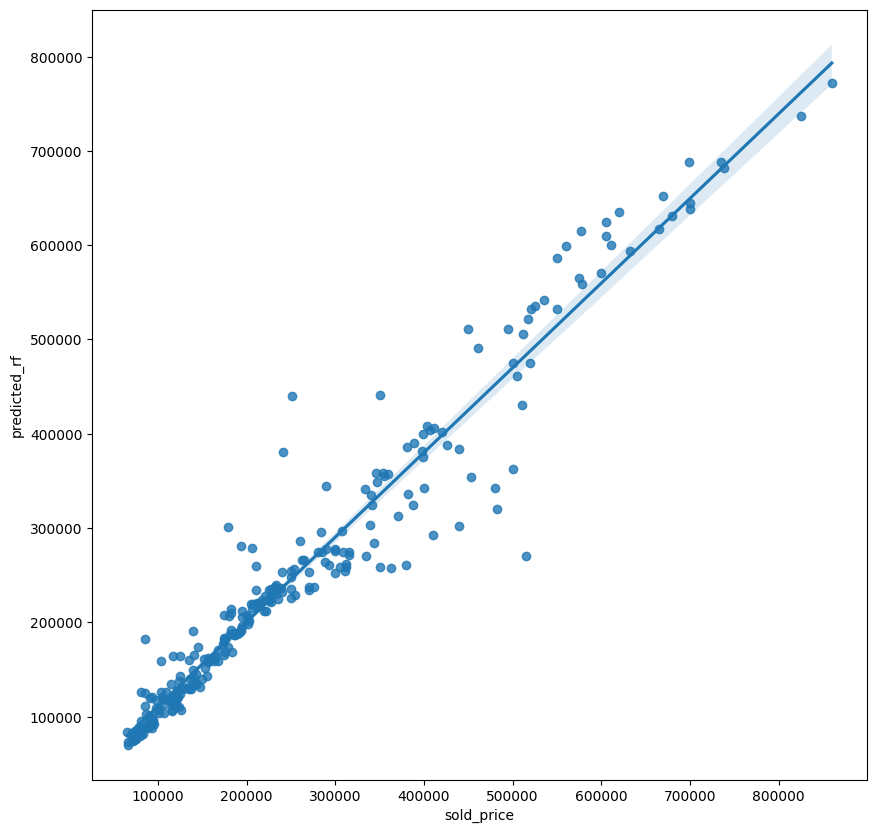

In [19]:
# Plot true vs predicted values scatter

plt.figure(figsize = (10, 10))
sns.regplot(x=X_analysis.sold_price, y=X_analysis.predicted_rf)
#sns.regplot(x=X_analysis.sold_price, y=X_analysis.predicted_xgb)

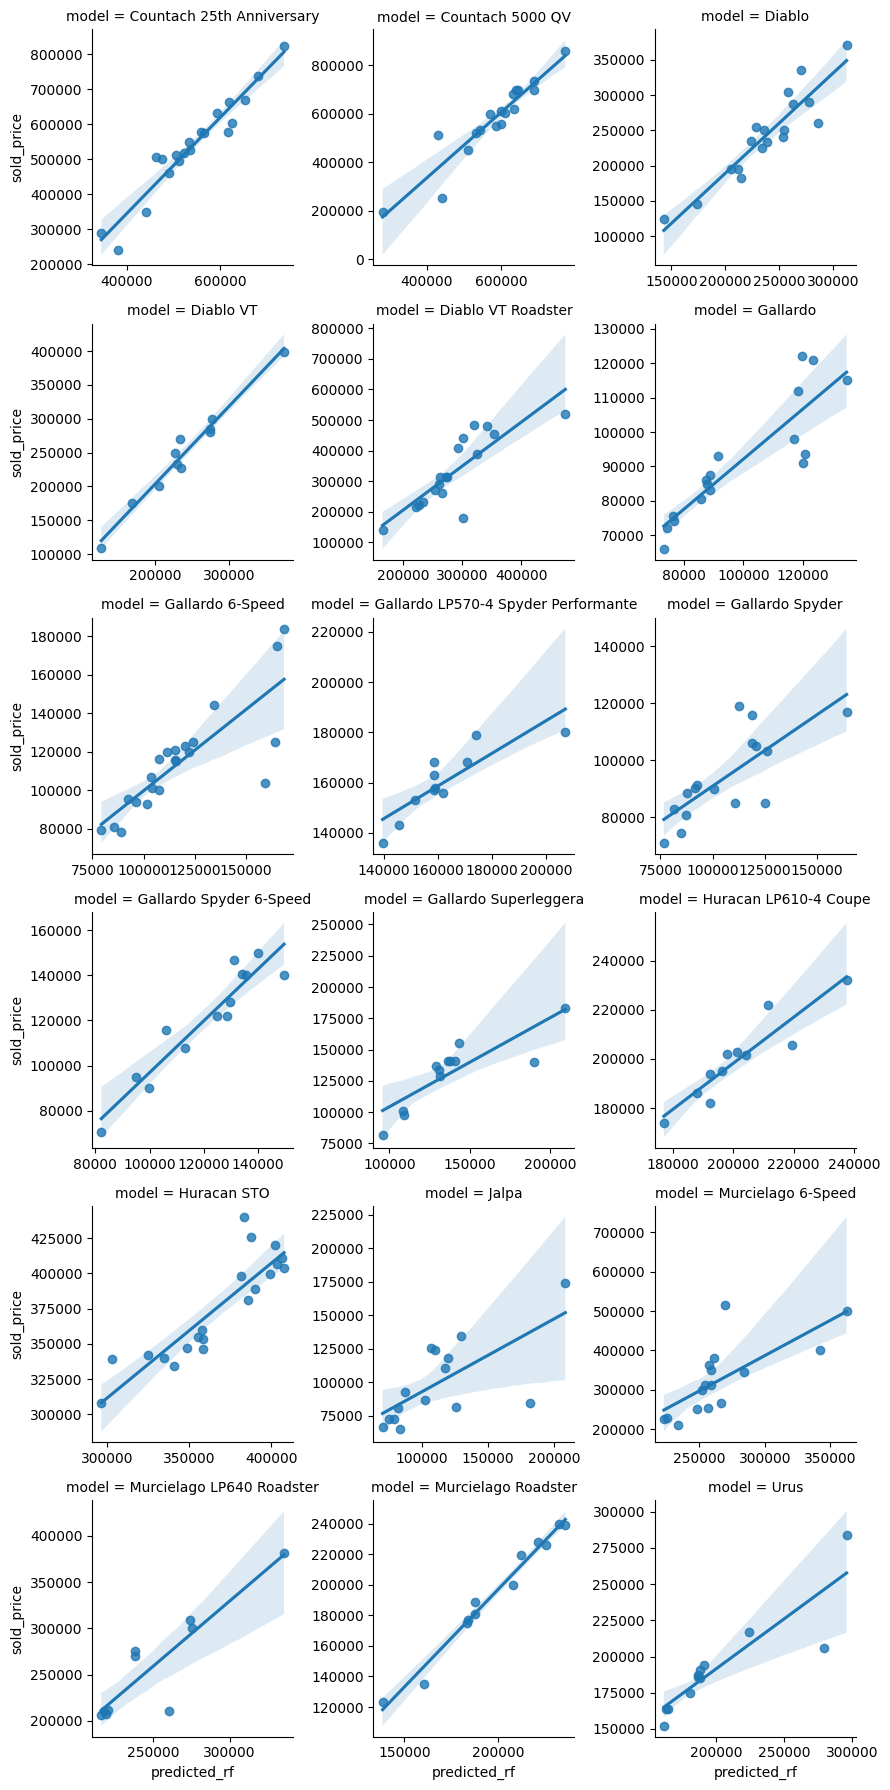

In [21]:
# Predicted vs Sold Price Scatter by model
g = sns.FacetGrid(X_analysis, col="model", col_wrap=3, sharex=False, sharey=False)

# Map scatter plots to the grid
g.map(sns.regplot, "predicted_rf", "sold_price")

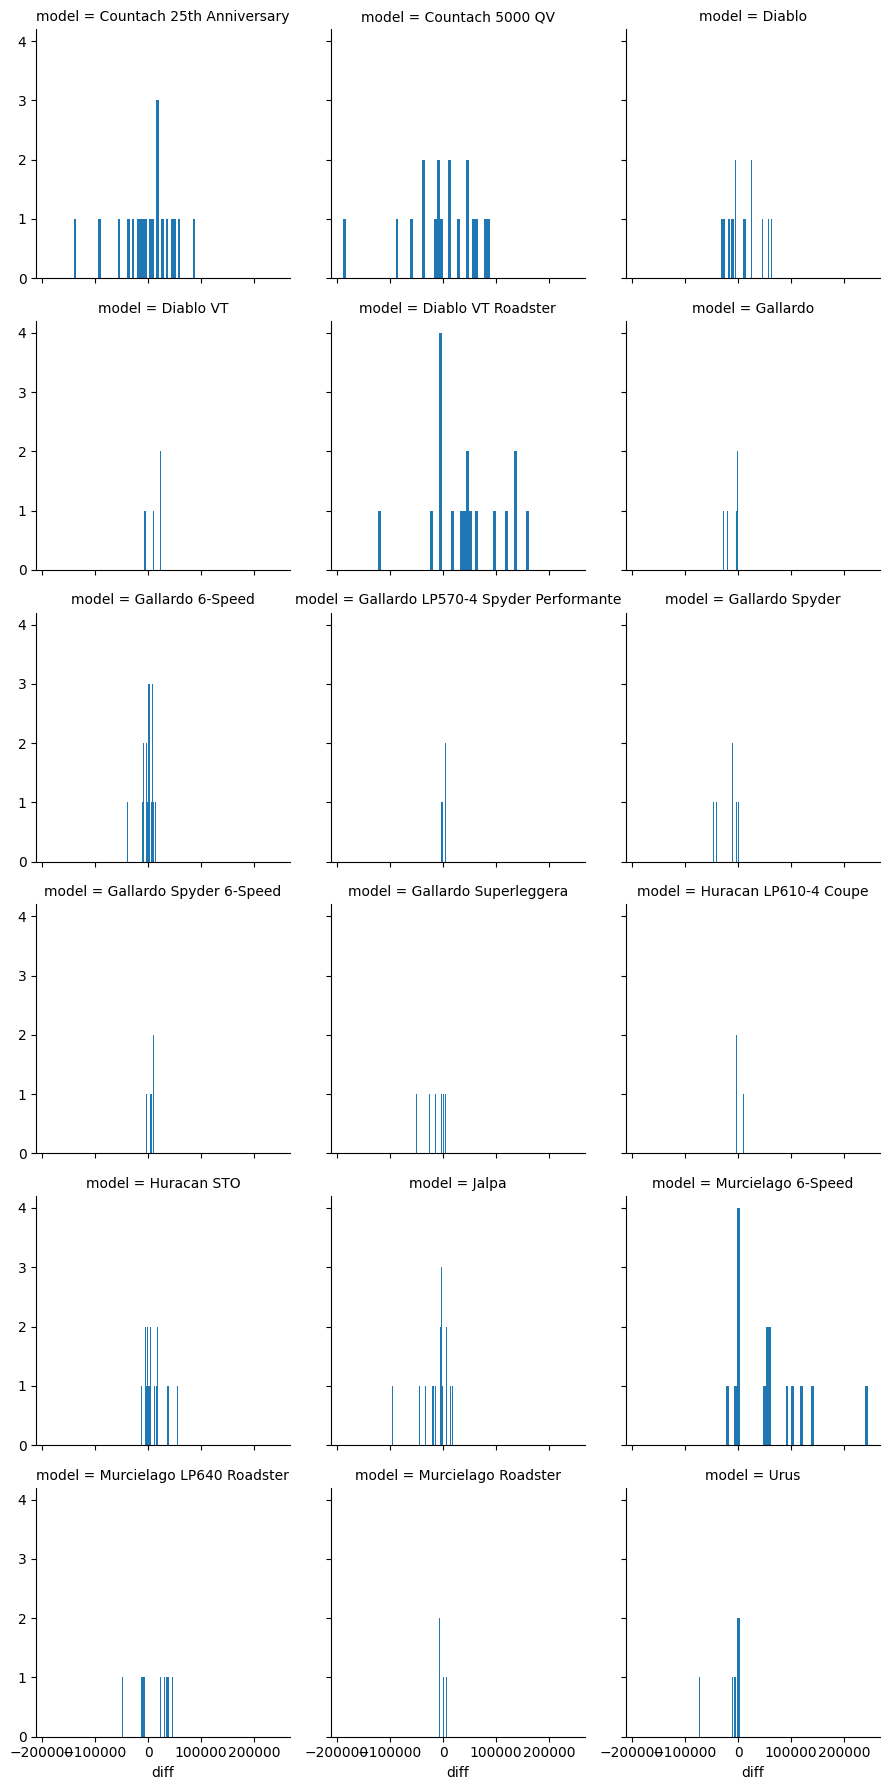

In [22]:
# Analyze Residuals by model
X_analysis['diff'] = X_analysis.sold_price - X_analysis.predicted_rf
g = sns.FacetGrid(X_analysis, col="model", col_wrap=3)

# Map scatter plots to the grid
g.map(plt.hist, "diff", bins = 50)


In [23]:
# Prediction function

def predict(year, model, mileage, color, transmission, carmodel, W):
    input_data = pd.DataFrame([[year, model, mileage, color, transmission, W]], 
                              columns=["year", "model", "mileage", "normalized_color", "transmission", "W"])
    input_data.model=Lbl_model.transform(input_data.model)
    input_data.normalized_color=Lbl_color.transform(input_data.normalized_color)
    input_data.transmission=Lbl_trans.transform(input_data.transmission)
    input_data.mileage = np.log1p(input_data.mileage)
    price_scaled = carmodel.predict(input_data)

    price = np.exp(price_scaled)
    
    return price[0].round(0)

In [24]:
# Run a prediction for a car over a range of mileage
mileage_range = np.linspace(0, 50000, 100)

predictions = []
for mileage in mileage_range:
    prediction = predict(
        year = 1992,
        model = "512 TR",
        mileage = mileage,
        color = "Black",
        transmission = "manual",
        carmodel = car_model_rf,
        W = 1
    )
    predictions.append(prediction)

predictions = pd.DataFrame(predictions, columns=["predicted"])
mileage_range = pd.DataFrame(mileage_range, columns=["mileage"])
predictions = pd.merge(predictions, mileage_range, how='inner', left_index=True, right_index=True)
plt.scatter(predictions["mileage"], predictions["predicted"])

ValueError: y contains previously unseen labels: '512 TR'